# Statistical Machine Learning

- **K-Nearest Neighbors**
    - A Small Example: Predicting Loan Default
    - Distance Metrics
    - One Hot Encoder
    - Standardization (Normalization, z-Scores)
    - Choosing K
    - KNN as a Feature Engine
- **Tree Models**
    - A Simple Example
    - The Recursive Partitioning Algorithm
    - Measuring Homogeneity or Impurity
    - Stopping the Tree from Growing
    - Predicting a Continuous Value
    - How Trees Are Used
    - Further Reading
- **Bagging and the Random Forest**
    - Bagging
    - Random Forest
    - Variable Importance
    - Hyperparameters
- **Boosting**
    - The Boosting Algorithm              
    - XGBoost
    - Regularization: Avoiding Overfitting
    - Hyperparameters and Cross-Validation

### Machine Learning Versus Statistics

Machine learning tends to be focused
more on developing efficient algorithms that scale to large data in
order to optimize the predictive model. Statistics generally pays
more attention to the probabilistic theory and underlying structure
of the model. 

Bagging, and the random forest, grew up firmly in the statistics
camp. Boosting, on the other hand, has been developed in both disciplines but receives more attention on the machine learning side of the divide. Regardless of the history, the promise of boosting ensures that it will thrive as a technique in both statistics and machine learning.

## K-Nearest Neighbors

The idea behind K-Nearest Neighbors (KNN) is very simple. For each record to be classified or predicted:
1. Find K records that have similar features (i.e., similar predictor values).
2. For classification, find out what the majority class is among those similar records and assign that class to the new record.
3. For prediction (also called KNN regression), find the average among those similar records, and predict that average for the new record.

Important key terms:
- **Neigbor**
- **Distance metrics**
- **Standardization**
- **z-score**
- **K**

The prediction results depend on how the features are scaled, how similarity is measured, and how big K is set. Also, all predictors must be in numeric form. We will illustrate how to use the KNN method with a classification example.

In [2]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
LOAN200_CSV = DATA / 'loan200.csv'
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

### A Small Example: Predicting Loan Default

In [5]:
loan200 = pd.read_csv(LOAN200_CSV)
 
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


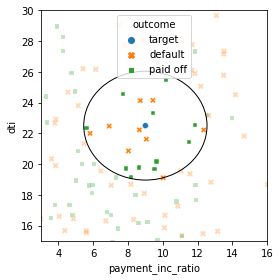

In [6]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

Note: The new loan to be predicted is the
cross in the middle. The greens (paid off) and oranges (default) are the training data. The large black circle shows the boundary of the nearest 20 points. In this case, 9 defaulted loans lie within the circle, as compared with 11 paid-off loans. Hence the predicted outcome of the loan is paid off. Note that if we consider only three nearest neighbors, the prediction would be that the loan defaults.

## Distance Metrics

Similarity (nearness) is determined using a distance metric, which is a function that measures how far two records $(x_1, x_2, …, x_p)$ and $(u_1, u_2, …, u_p)$ are from one another. The most popular distance metric between two vectors is *Euclidean distance*.

Another common distance metric for numeric data is *Manhattan distance*:

There are numerous other metrics for measuring distance between
vectors. For numeric data, *Mahalanobis distance*(the Euclidean distance between the principal components ) is attractive since
it accounts for the correlation between two variables. This is useful
since if two variables are highly correlated, Mahalanobis will essen‐
tially treat these as a single variable in terms of distance.The downside of using Mahalanobis distance is increased computational effort and complexity; it is computed using the *covariance matrix*.

## One Hot Encoder

The phrase *one hot encoding* comes from digital circuit terminology,
where it describes circuit settings in which only one bit is allowed to be positive (hot).

## Standardization (Normalization, z-Scores)

In measurement, we are often not so much interested in “how much” but in “how different from the average.” Standardization, also called *normalization*, puts all variables on similar scales by subtracting the mean and dividing by the standard deviation; in this way, we ensure that a variable does not overly influence a model simply due to
the scale of its original measurement:

$$
z =\frac{x-\bar{x}}{s}
$$

The result of this transformation is commonly referred to as a *z-score*. Measurements are then stated in terms of “standard deviations away from the mean.”

In [7]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [8]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


## Choosing K
The choice of K is very important to the performance of KNN. Setting $K=1$ is rarely the best choice; you’ll almost always obtain superior performance by using $K >$ 1-nearest neighbors.

Generally speaking, if K is too low, we may be overfitting: including the noise in the data. Higher values of K provide smoothing that reduces the risk of overfitting in the training data. On the other hand, if K is too high, we may oversmooth the data and miss out on KNN’s ability to capture the local structure in the data, one of its main advantages.

The K that best balances between overfitting and oversmoothing is typically determined by accuracy metrics and, in particular, accuracy with holdout or validation data. There is no general rule about the best K—it depends greatly on the nature of the data. For highly structured data with little noise, smaller values of K work best.
Borrowing a term from the signal processing community, this type of data is sometimes referred to as having a high *signal-to-noise* ratio (SNR). Examples of data with a typically high SNR are data sets for handwriting and speech recognition. For noisy data with less structure (data with a low SNR), such as the loan data, larger values of K are appropriate. Typically, values of K fall in the range 1 to 20. Often, an odd number is chosen to avoid ties.

## KNN as a Feature Engine

KNN can be used to add “local
knowledge” in a staged process with other classification techniques:

1. KNN is run on the data, and for each record, a classification (or quasi-probability of a class) is derived.

2. That result is added as a new feature to the record, and another classification method is then run on the data. The original predictor variables are thus used twice.

At first you might wonder whether this process, since it uses some predictors twice, causes a problem with multicollinearity. This is
not an issue, since the information being incorporated into the second-stage model is highly local, derived only from a few nearby records, and is therefore additional information and not redundant.

count    45342.000000
mean         0.501099
std          0.128735
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


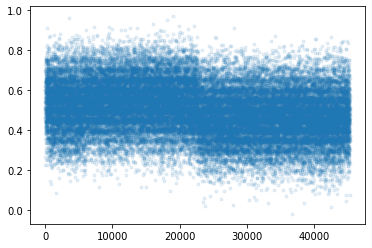

In [9]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

## Tree Models

Tree models, also called *Classification and Regression Trees* (CART), decision trees, or just *trees*, are an effective and popular classification (and regression) method initially developed by Leo Breiman and others in 1984. Tree models, and their more powerful descendants random forests and boosted trees, form the basis for the most widely used and powerful predictive modeling tools in data science for regression and classification.

Important key terms:
- **Recursive partitioning**
- **Split value**
- **Node**
- **Leaf**
- **Loss**
- **Impurity**
- **Pruning**

## As Simple Example

[Text(0.5, 0.875, 'X[0] <= 0.575\nentropy = 0.999\nsamples = 3000\nvalue = [1445, 1555]'),
 Text(0.2, 0.625, 'X[0] <= 0.325\nentropy = 0.99\nsamples = 2122\nvalue = [1184, 938]'),
 Text(0.1, 0.375, 'entropy = 0.751\nsamples = 265\nvalue = [208, 57]'),
 Text(0.3, 0.375, 'X[1] <= 10.423\nentropy = 0.998\nsamples = 1857\nvalue = [976, 881]'),
 Text(0.2, 0.125, 'entropy = 1.0\nsamples = 1294\nvalue = [631, 663]'),
 Text(0.4, 0.125, 'entropy = 0.963\nsamples = 563\nvalue = [345, 218]'),
 Text(0.8, 0.625, 'X[1] <= 9.191\nentropy = 0.878\nsamples = 878\nvalue = [261, 617]'),
 Text(0.7, 0.375, 'X[0] <= 0.725\nentropy = 0.766\nsamples = 600\nvalue = [134, 466]'),
 Text(0.6, 0.125, 'entropy = 0.807\nsamples = 518\nvalue = [128, 390]'),
 Text(0.8, 0.125, 'entropy = 0.378\nsamples = 82\nvalue = [6, 76]'),
 Text(0.9, 0.375, 'entropy = 0.995\nsamples = 278\nvalue = [127, 151]')]

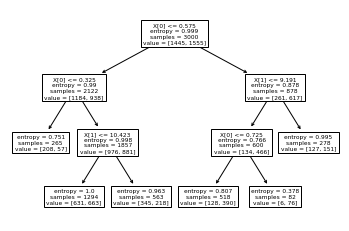

In [10]:
from sklearn import tree

loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
tree.plot_tree(loan_tree)

## The Recursive Partitioning Algorithm
Suppose we have a response variable Y and a set of P predictor variables $X_j$
for $j = 1,⋯,P$. For a partition A of records, recursive partitioning will find the best way to partition A into two subpartitions:

1. For each predictor variable $X_j$:
    - For each value $s_j$ of $X_j$:
        - Split the records in A with $X_j$ values $< s_j$ as one partition, and the remaining records where $X_j \geq s_j$ as another partition.
        - Measure the homogeneity of classes within each subpartition of A.
    - Select the value of $s_j$ that produces maximum within-partition homogeneity of class.
2. Select the variable $X_j$ and the split value $s_j$ that produces maximum within partition homogeneity of class.

Now comes the recursive part:
1. Initialize A with the entire data set.
2. Apply the partitioning algorithm to split A into two subpartitions, $A_1$ and $A_2$.
3. Repeat step 2 on subpartitions $A_1$ and $A_2$.
4. The algorithm terminates when no further partition can be made that sufficiently improves the homogeneity of the partitions.

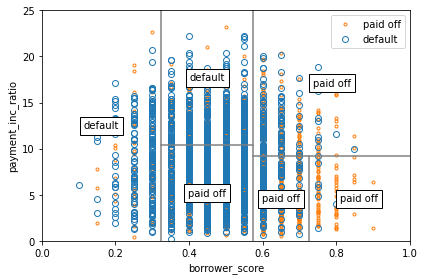

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default'])
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

## Measuring Homogeneity or Impurity
Two common measures for impurity are the *Gini impurity* and *entropy* of information. The Gini impurity for a set of records A is:

$$
I(A) = p(1-p)
$$

The entropy measure is given by:

$$
I(A) = -p \log(p) - (1-p)\log (1-p)
$$

In [12]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

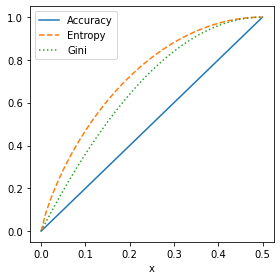

In [15]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

For each proposed partition of the data, impurity is measured for each of the partitions that result from the split. A weighted average is then calculated, and whichever partition (at each stage) yields the lowest weighted average is selected.

## Stopping the Tree from Growing

As the tree grows bigger, the splitting rules become more detailed, and the tree gradually shifts from identifying “big” rules that identify real and reliable relationships in the data to “tiny” rules that reflect only noise.

We need some way to determine when to stop growing a tree at a stage that will generalize to new data. There are various ways to stop splitting:

1. Python’s `DecisionTreeClassifier`, we can control this using the parameters
min_samples_split (default 2) and min_samples_leaf (default 1).
2. `DecisionTreeClassifier` (Python) has the parameter min_impurity_decrease, which limits splitting based on a weighted impurity decrease value. Here, smaller values will lead to more complex trees.

#### Controlling tree complexity in Python
Neither the complexity parameter nor pruning is available in scikit-learn’s decision tree implementation. The solution is to use grid search over combinations of different parameter values. For example, we can vary max_depth in the range 5 to 30 and `min_samples_split` between 20 and 100. The `GridSearchCV` method in scikitlearn is a convenient way to combine the exhaustive search through all combinations with cross-validation. An optimal parameter set is then selected using the crossvalidated model performance.

## Predicting a Continuous Value
Predicting a continuous value (also termed *regression*) with a tree follows the same logic and procedure, except that impurity is measured by **squared deviations from the mean** (squared errors) in each subpartition, and predictive performance is judged by the square root of the mean squared error (RMSE) in each partition.

## How Trees Are Used
- Tree models provide a visual tool for exploring the data, to gain an idea of what variables are important and how they relate to one another. Trees can capture nonlinear relationships among predictor variables.
- Tree models provide a set of rules that can be effectively communicated to non‐specialists, either for implementation or to “sell” a data mining project.

## Bagging and the Random Forest

Important key terms:
- **Ensemble**
- **Bagging**(Bootstrap aggregation)
- **Random forest**
- **Variable importance**

## Bagging

Suppose we have a response Y and P predictor variables $X = X_1, X_2, ⋯, X_P$ with N records. Each new model is fitted to a bootstrap resample.Here is the algorithm presented more formally:

1. Initialize M, the number of models to be fit, and n, the number of records to choose ($n < N$). Set the iteration $m= 1$.
2. Take a bootstrap resample (i.e., with replacement) of n records from the training data to form a subsample $Y_m$ and $X_m$ (the bag).
3. Train a model using $Y_m$ and $X_m$ to create a set of decision rules $\hat{f_m}(X)$.
4. Increment the model counter $m = m + 1$. If $m \leq M$, go to step 2.

In the case where $\hat{f_m}$ predicts the probability $Y= 1$, the bagged estimate is given by:

$$
\hat{f} = \frac{1}{M}(\hat{f_1}(X)+\dots+\hat{f_M}(X))
$$

## Random Forest

The random forest is based on applying bagging to decision trees, with one important extension: in addition to sampling the records, the algorithm also samples the variables.

With random forests, at each stage of the algorithm, the choice of variable is
limited to a *random subset of variables*. The random forest algorithm adds two more steps: the bagging discussed earlier, and the bootstrap sampling of variables at each split:

1. Take a bootstrap (with replacement) subsample from the records.
2. For the first split, sample $p < P$ variables at random without replacement.
3. For each of the sampled variables $X_{j(1)}, X_{j(2)}, ..., X_{j(p)}$, apply the splitting algorithm:
    - For each value $s_{j(k)}$ of $X_{j(k)}$:
        - Split the records in partition A, with $X_{j(k)} < s_{j(k)}$ as one partition and the remaining records where $X_{j(k)} \geq s_{j(k)}$ as another partition.
        - Measure the homogeneity of classes within each subpartition of A.
    - Select the value of $s_{j(k)}$ that produces maximum within-partition homogeneity of class
4. Select the variable $X_{j(k)}$ and the split value $s_{j(k)}$ that produces maximum within-partition homogeneity of class.
5. Proceed to the next split and repeat the previous steps, starting with step 2.
6. Continue with additional splits, following the same procedure until the tree is
grown.
7. Go back to step 1, take another bootstrap subsample, and start the process over
again.

How many variables to sample at each step? A rule of thumb is to choose $\sqrt{P}$ where $P$
is the number of predictor variables.

In [16]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


The out-of-bag (OOB) estimate of error is the error rate for the trained models,
applied to the data left out of the training set for that tree. Using the output from the
model, the OOB error can be plotted versus the number of trees in the random forest

In [17]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

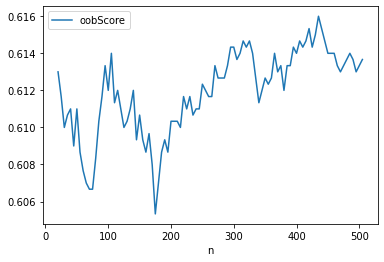

In [18]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

The random forest method is a “black box” method. It produces more accurate pre‐
dictions than a simple tree, but the simple tree’s intuitive decision rules are lost. The
random forest predictions are also somewhat noisy: note that some borrowers with a
very high score, indicating high creditworthiness, still end up with a prediction of
default. This is a result of some unusual records in the data and demonstrates the
danger of overfitting by the random forest

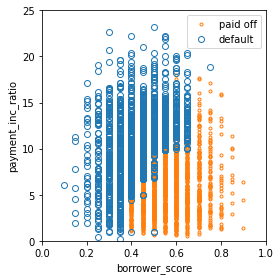

In [19]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()